<h2>Results from varying co-fed gases</h2>

In [1]:
# Some imports to stop some annoying yellow underlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Very important line to run the setup notebook!!!
%run do_plot_setup.ipynb

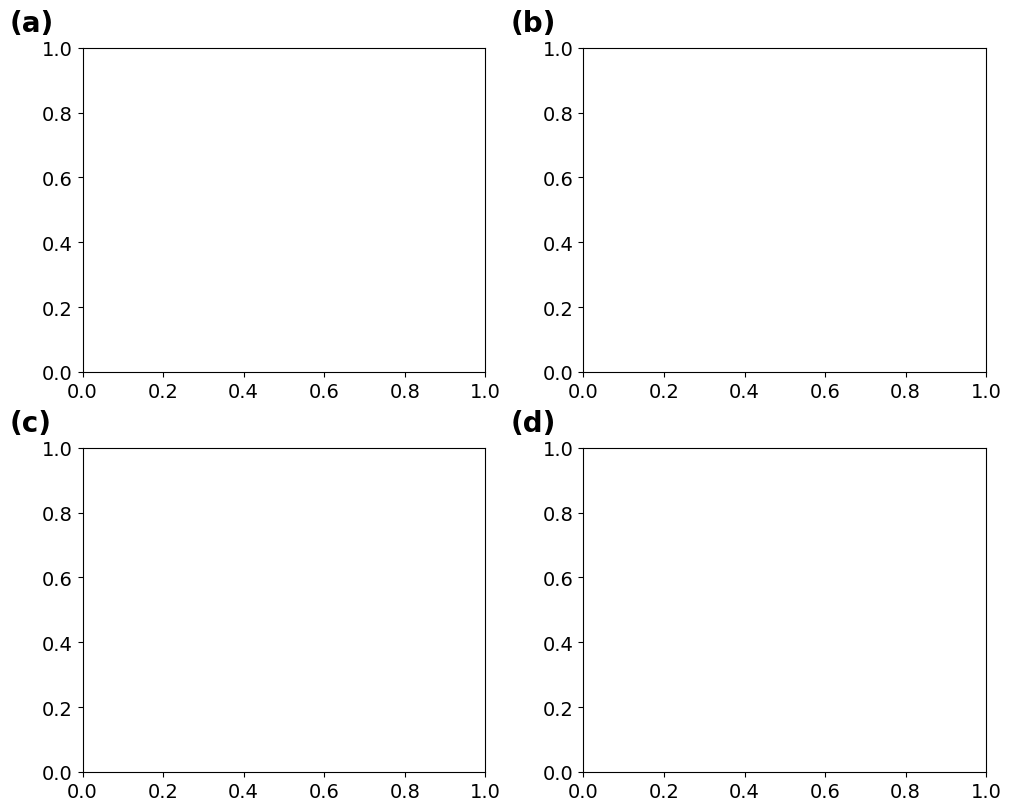

In [2]:
(fig,(((ax_a,ax_b),(ax_c,ax_d))))=plt.subplots(2,2,figsize=(figure_width,8))

# a
ax_a.text(-0.18,1.05, "(a)", transform=ax_a.transAxes, size=subplot_letter_size, weight='bold')

# b
ax_b.text(-0.18,1.05, "(b)", transform=ax_b.transAxes, size=subplot_letter_size, weight='bold')

# c
ax_c.text(-0.18,1.05, "(c)", transform=ax_c.transAxes, size=subplot_letter_size, weight='bold')

# d
ax_d.text(-0.18,1.05, "(d)", transform=ax_d.transAxes, size=subplot_letter_size, weight='bold')

plt.savefig('exported_images/vary_co_fed_gases_results.png', bbox_inches='tight',dpi=300)
plt.show()